In [45]:
import os
from PIL import Image
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
import warnings

In [46]:
# Read the dataset, and check all the class names

## warnings.filterwarnings("ignore")

dataset_path = './Datasets/yoga-posture/Edited_Enhanced'
classes = os.listdir(dataset_path)
classes

['Navasana',
 'Hanumanasana',
 'Phalakasana',
 'Ardha Navasana',
 'Utkata Konasana',
 'Adho Mukha Svanasana',
 'Sivasana',
 'Padmasana',
 'Salamba Bhujangasana',
 'Supta Kapotasana',
 'Upavistha Konasana',
 'Utthita Hasta Padangusthasana',
 'Ardha Pincha Mayurasana',
 'Camatkarasana',
 'Malasana',
 'Uttanasana',
 'Parsva Virabhadrasana',
 'Ustrasana',
 'Baddha Konasana',
 'Utkatasana',
 'Virabhadrasana Three',
 'Vasisthasana',
 'Bakasana',
 'Ardha Chandrasana',
 'Vrksasana',
 'Utthita Parsvakonasana',
 'Anjaneyasana',
 'Salamba Sarvangasana',
 'Ardha Matsyendrasana',
 'Paschimottanasana',
 'Garudasana',
 'Setu Bandha Sarvangasana',
 'Halasana',
 'Pincha Mayurasana',
 'Trikonasana',
 'Urdhva Dhanurasana',
 'Virabhadrasana One',
 'Bitilasana',
 'Adho Mukha Vrksasana',
 'Balasana',
 'Virabhadrasana Two',
 'Urdhva Mukha Svsnssana',
 'Eka Pada Rajakapotasana',
 'Dhanurasana',
 'Marjaryasana',
 'Parsvottanasana']

In [47]:

class_label = ClassLabel(names=classes, num_classes=len(classes))

data = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                image = Image.open(img_path).convert("RGB")
                data.append({
                    'image': image,
                    'image_file_path': img_path,
                    'labels': class_label.str2int(class_name)
                })

data[:1]

/opt/anaconda3/envs/aai/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/envs/aai/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


[{'image': <PIL.Image.Image image mode=RGB size=268x188>,
  'image_file_path': './Datasets/yoga-posture/Edited_Enhanced/Navasana/File3.jpeg',
  'labels': 0}]

In [48]:

# Split data into train, validation and test
# train: 0.8, validation: 0.15, test: 0.05
train_data, val_data = train_test_split(data, test_size=0.2, stratify=[item['labels'] for item in data])
val_data, test_data = train_test_split(val_data, test_size=0.25, stratify=[item['labels'] for item in val_data]) 


In [49]:
# Transform data into HuggingFace Dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x173ADA390>, 'image_file_path': './Datasets/yoga-posture/Edited_Enhanced/Phalakasana/File54.jpg', 'labels': 2}
labels: 2, class name: Phalakasana


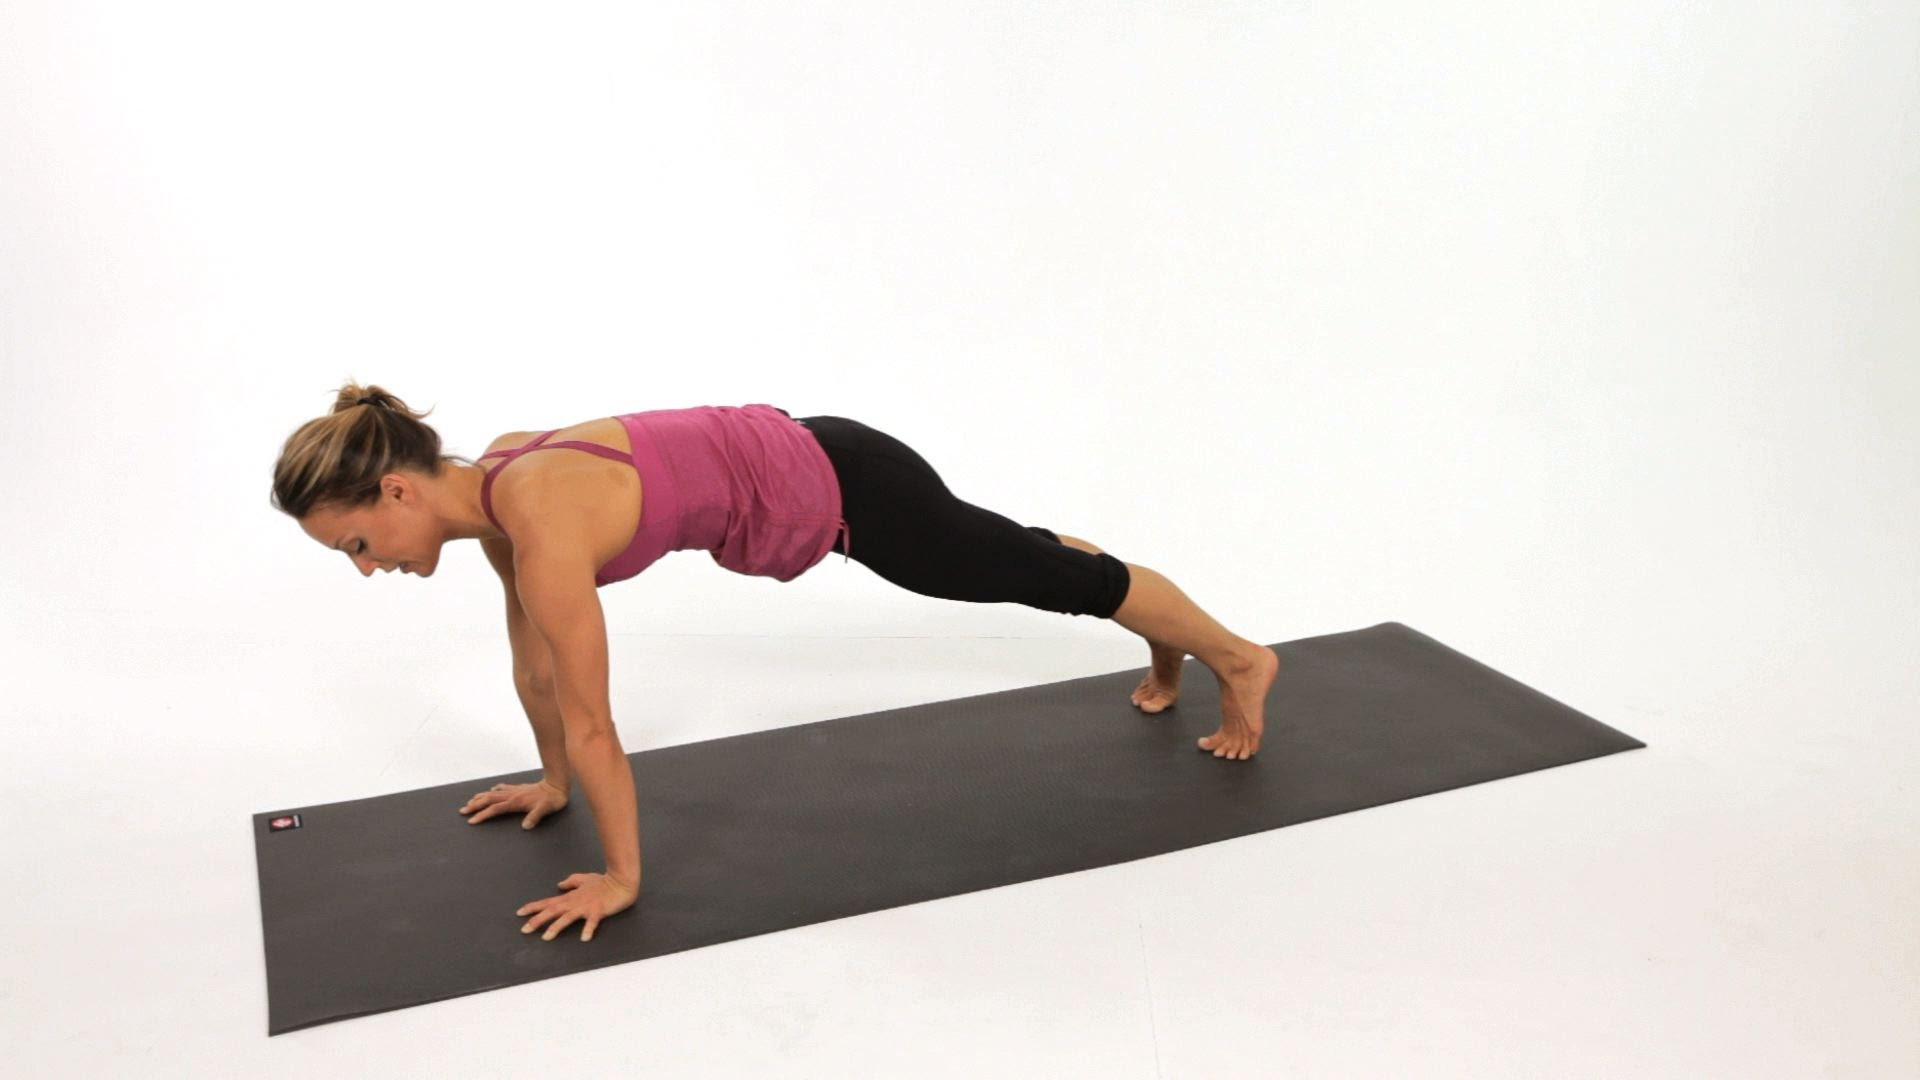

In [50]:
# Look at an example
ex = dataset_dict['train'][1000]
print(ex)
labels = ex['labels']
print(f"labels: {labels}, class name: {class_label.int2str(labels)}")
ex['image']

In [51]:
# Use the ViTFeatureExtractor to extract features from the images
from transformers import ViTFeatureExtractor

# The pre-trained model: https://huggingface.co/google/vit-base-patch16-224-in21k
# Vision Transformer (ViT) model is pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

# This feature extractor is initialized with a default configuration that was saved along with the pretrained model
feature_extractor

/opt/anaconda3/envs/aai/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [52]:
# An example of extracting features from an image, and the output is a PyTorch tensor
image = ex['image']
inputs = feature_extractor(images=image, return_tensors="pt")
inputs

{'pixel_values': tensor([[[[0.9843, 0.9843, 0.9922,  ..., 0.8588, 0.8588, 0.8510],
          [0.9843, 0.9843, 0.9922,  ..., 0.8588, 0.8588, 0.8510],
          [0.9843, 0.9922, 0.9922,  ..., 0.8667, 0.8588, 0.8588],
          ...,
          [0.8745, 0.8745, 0.8588,  ..., 0.8431, 0.8431, 0.8431],
          [0.8824, 0.8824, 0.8745,  ..., 0.8510, 0.8431, 0.8431],
          [0.8824, 0.8824, 0.8824,  ..., 0.8510, 0.8510, 0.8353]],

         [[0.9529, 0.9529, 0.9608,  ..., 0.8588, 0.8667, 0.8588],
          [0.9529, 0.9529, 0.9608,  ..., 0.8588, 0.8667, 0.8588],
          [0.9529, 0.9608, 0.9608,  ..., 0.8667, 0.8667, 0.8667],
          ...,
          [0.8118, 0.8196, 0.8196,  ..., 0.7882, 0.7882, 0.7882],
          [0.8196, 0.8196, 0.8275,  ..., 0.7961, 0.7882, 0.7882],
          [0.8196, 0.8196, 0.8275,  ..., 0.7961, 0.7961, 0.7804]],

         [[0.9451, 0.9451, 0.9529,  ..., 0.8431, 0.8275, 0.8196],
          [0.9451, 0.9451, 0.9529,  ..., 0.8431, 0.8275, 0.8196],
          [0.9451, 0.9529

In [53]:
# Define a transform function and apply it to the dataset
def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')

    inputs['labels'] = batch['labels']
    return inputs

prepared_ds = dataset_dict.with_transform(transform)
prepared_ds['train'][:2]

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1

### Use HuggingFace Trainer to train the model
- Define a data collator
- Define an evaluation metric
- Load a pretrained checkpoint and configure it for training.
- Define the training configuration.

In [54]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [55]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)#

In [56]:
# Load pretrained model. 
# Add num_labels on init to make sure the model creates a classification head with the right number of units
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(classes)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-yoga-demo",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  use_cpu=True
)

/opt/anaconda3/envs/aai/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [58]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [59]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


  3%|▎         | 25/760 [15:32<44:49,  3.66s/it]

{'loss': 3.724, 'grad_norm': 2.223261833190918, 'learning_rate': 0.00019736842105263157, 'epoch': 0.05}



  3%|▎         | 25/760 [16:07<44:49,  3.66s/it]

{'loss': 3.5544, 'grad_norm': 1.9181140661239624, 'learning_rate': 0.00019473684210526317, 'epoch': 0.11}



  3%|▎         | 25/760 [16:43<44:49,  3.66s/it]

{'loss': 3.3135, 'grad_norm': 1.994871973991394, 'learning_rate': 0.00019210526315789473, 'epoch': 0.16}



  3%|▎         | 25/760 [17:18<44:49,  3.66s/it]

{'loss': 2.9729, 'grad_norm': 1.8174664974212646, 'learning_rate': 0.00018947368421052632, 'epoch': 0.21}



  3%|▎         | 25/760 [17:54<44:49,  3.66s/it]

{'loss': 2.8261, 'grad_norm': 2.0153605937957764, 'learning_rate': 0.00018684210526315792, 'epoch': 0.26}



  3%|▎         | 25/760 [18:34<44:49,  3.66s/it]

{'loss': 2.4432, 'grad_norm': 1.8649307489395142, 'learning_rate': 0.00018421052631578948, 'epoch': 0.32}



  3%|▎         | 25/760 [19:12<44:49,  3.66s/it]

{'loss': 2.3639, 'grad_norm': 2.0311567783355713, 'learning_rate': 0.00018157894736842107, 'epoch': 0.37}



  3%|▎         | 25/760 [19:51<44:49,  3.66s/it]

{'loss': 2.1484, 'grad_norm': 2.19073748588562, 'learning_rate': 0.00017894736842105264, 'epoch': 0.42}



  3%|▎         | 25/760 [20:30<44:49,  3.66s/it]

{'loss': 1.8776, 'grad_norm': 2.2391955852508545, 'learning_rate': 0.0001763157894736842, 'epoch': 0.47}



  3%|▎         | 25/760 [21:07<44:49,  3.66s/it] 

{'loss': 1.699, 'grad_norm': 1.8319501876831055, 'learning_rate': 0.0001736842105263158, 'epoch': 0.53}












































































                                         
                                                 
  3%|▎         | 25/760 [21:53<44:49,  3.66s/it]


{'eval_loss': 1.5795234441757202, 'eval_accuracy': 0.8368421052631579, 'eval_runtime': 45.1347, 'eval_samples_per_second': 12.629, 'eval_steps_per_second': 1.595, 'epoch': 0.53}



  3%|▎         | 25/760 [22:31<44:49,  3.66s/it] 

{'loss': 1.5154, 'grad_norm': 2.4223153591156006, 'learning_rate': 0.00017105263157894739, 'epoch': 0.58}



  3%|▎         | 25/760 [23:06<44:49,  3.66s/it] 

{'loss': 1.4703, 'grad_norm': 1.9405595064163208, 'learning_rate': 0.00016842105263157895, 'epoch': 0.63}



  3%|▎         | 25/760 [23:42<44:49,  3.66s/it] 

{'loss': 1.2503, 'grad_norm': 1.6881661415100098, 'learning_rate': 0.00016578947368421054, 'epoch': 0.68}



  3%|▎         | 25/760 [24:18<44:49,  3.66s/it] 

{'loss': 1.1023, 'grad_norm': 1.7179023027420044, 'learning_rate': 0.0001631578947368421, 'epoch': 0.74}



  3%|▎         | 25/760 [24:53<44:49,  3.66s/it] 

{'loss': 1.0337, 'grad_norm': 1.4693958759307861, 'learning_rate': 0.0001605263157894737, 'epoch': 0.79}



  3%|▎         | 25/760 [25:29<44:49,  3.66s/it] 

{'loss': 0.9504, 'grad_norm': 2.2560582160949707, 'learning_rate': 0.00015789473684210527, 'epoch': 0.84}



  3%|▎         | 25/760 [26:04<44:49,  3.66s/it] 

{'loss': 0.8606, 'grad_norm': 1.7854210138320923, 'learning_rate': 0.00015526315789473686, 'epoch': 0.89}



  3%|▎         | 25/760 [32:43<44:49,  3.66s/it]   

{'loss': 0.7794, 'grad_norm': 1.4096728563308716, 'learning_rate': 0.00015263157894736845, 'epoch': 0.95}



  3%|▎         | 25/760 [33:17<44:49,  3.66s/it] 

{'loss': 0.6709, 'grad_norm': 1.3070104122161865, 'learning_rate': 0.00015000000000000001, 'epoch': 1.0}



  3%|▎         | 25/760 [33:52<44:49,  3.66s/it] 

{'loss': 0.556, 'grad_norm': 0.8639750480651855, 'learning_rate': 0.00014736842105263158, 'epoch': 1.05}











































































                                                 

  3%|▎         | 25/760 [34:35<44:49,  3.66s/it]



{'eval_loss': 0.6414439678192139, 'eval_accuracy': 0.9508771929824561, 'eval_runtime': 43.499, 'eval_samples_per_second': 13.104, 'eval_steps_per_second': 1.655, 'epoch': 1.05}



  3%|▎         | 25/760 [35:17<44:49,  3.66s/it] 

{'loss': 0.5076, 'grad_norm': 1.3370893001556396, 'learning_rate': 0.00014473684210526317, 'epoch': 1.11}



  3%|▎         | 25/760 [36:00<44:49,  3.66s/it] 

{'loss': 0.4719, 'grad_norm': 1.3176171779632568, 'learning_rate': 0.00014210526315789474, 'epoch': 1.16}



  3%|▎         | 25/760 [36:40<44:49,  3.66s/it] 

{'loss': 0.4003, 'grad_norm': 0.8075427412986755, 'learning_rate': 0.0001394736842105263, 'epoch': 1.21}



  3%|▎         | 25/760 [37:18<44:49,  3.66s/it] 

{'loss': 0.3587, 'grad_norm': 1.3658292293548584, 'learning_rate': 0.0001368421052631579, 'epoch': 1.26}



  3%|▎         | 25/760 [37:55<44:49,  3.66s/it] 

{'loss': 0.4019, 'grad_norm': 2.846092462539673, 'learning_rate': 0.00013421052631578948, 'epoch': 1.32}



  3%|▎         | 25/760 [38:33<44:49,  3.66s/it] 

{'loss': 0.3397, 'grad_norm': 0.7014585733413696, 'learning_rate': 0.00013157894736842108, 'epoch': 1.37}



  3%|▎         | 25/760 [39:10<44:49,  3.66s/it] 

{'loss': 0.3355, 'grad_norm': 1.374963641166687, 'learning_rate': 0.00012894736842105264, 'epoch': 1.42}



  3%|▎         | 25/760 [39:43<44:49,  3.66s/it] 

{'loss': 0.3084, 'grad_norm': 0.9433276057243347, 'learning_rate': 0.0001263157894736842, 'epoch': 1.47}



  3%|▎         | 25/760 [40:17<44:49,  3.66s/it] 

{'loss': 0.2451, 'grad_norm': 2.462670087814331, 'learning_rate': 0.0001236842105263158, 'epoch': 1.53}



  3%|▎         | 25/760 [40:51<44:49,  3.66s/it] 

{'loss': 0.2156, 'grad_norm': 0.5171413421630859, 'learning_rate': 0.00012105263157894738, 'epoch': 1.58}











































































                                                 

  3%|▎         | 25/760 [41:34<44:49,  3.66s/it]



{'eval_loss': 0.3058823347091675, 'eval_accuracy': 0.968421052631579, 'eval_runtime': 42.7608, 'eval_samples_per_second': 13.33, 'eval_steps_per_second': 1.684, 'epoch': 1.58}



  3%|▎         | 25/760 [42:10<44:49,  3.66s/it] 

{'loss': 0.2424, 'grad_norm': 0.423208624124527, 'learning_rate': 0.00011842105263157894, 'epoch': 1.63}



  3%|▎         | 25/760 [42:49<44:49,  3.66s/it] 

{'loss': 0.1847, 'grad_norm': 1.7326405048370361, 'learning_rate': 0.00011578947368421053, 'epoch': 1.68}



  3%|▎         | 25/760 [43:26<44:49,  3.66s/it] 

{'loss': 0.2349, 'grad_norm': 2.312084913253784, 'learning_rate': 0.00011315789473684211, 'epoch': 1.74}



  3%|▎         | 25/760 [44:05<44:49,  3.66s/it] 

{'loss': 0.2301, 'grad_norm': 0.6789647936820984, 'learning_rate': 0.0001105263157894737, 'epoch': 1.79}



  3%|▎         | 25/760 [44:42<44:49,  3.66s/it] 

{'loss': 0.1936, 'grad_norm': 0.40587133169174194, 'learning_rate': 0.00010789473684210527, 'epoch': 1.84}



  3%|▎         | 25/760 [45:17<44:49,  3.66s/it] 

{'loss': 0.1944, 'grad_norm': 1.7953859567642212, 'learning_rate': 0.00010526315789473685, 'epoch': 1.89}



  3%|▎         | 25/760 [45:53<44:49,  3.66s/it] 

{'loss': 0.175, 'grad_norm': 1.7355610132217407, 'learning_rate': 0.00010263157894736844, 'epoch': 1.95}



  3%|▎         | 25/760 [46:27<44:49,  3.66s/it] 

{'loss': 0.227, 'grad_norm': 0.5449004769325256, 'learning_rate': 0.0001, 'epoch': 2.0}



  3%|▎         | 25/760 [47:01<44:49,  3.66s/it] 

{'loss': 0.151, 'grad_norm': 0.2912715673446655, 'learning_rate': 9.736842105263158e-05, 'epoch': 2.05}



  3%|▎         | 25/760 [47:35<44:49,  3.66s/it] 

{'loss': 0.1364, 'grad_norm': 1.4682888984680176, 'learning_rate': 9.473684210526316e-05, 'epoch': 2.11}











































































                                                 

  3%|▎         | 25/760 [48:17<44:49,  3.66s/it]



{'eval_loss': 0.2212885469198227, 'eval_accuracy': 0.9596491228070175, 'eval_runtime': 42.2304, 'eval_samples_per_second': 13.497, 'eval_steps_per_second': 1.705, 'epoch': 2.11}



  3%|▎         | 25/760 [1:05:54<44:49,  3.66s/it] 

{'loss': 0.16, 'grad_norm': 0.452780157327652, 'learning_rate': 9.210526315789474e-05, 'epoch': 2.16}



  3%|▎         | 25/760 [1:06:33<44:49,  3.66s/it]

{'loss': 0.1093, 'grad_norm': 0.4092981219291687, 'learning_rate': 8.947368421052632e-05, 'epoch': 2.21}



  3%|▎         | 25/760 [1:07:10<44:49,  3.66s/it]

{'loss': 0.0865, 'grad_norm': 0.20450244843959808, 'learning_rate': 8.68421052631579e-05, 'epoch': 2.26}



  3%|▎         | 25/760 [1:07:44<44:49,  3.66s/it]

{'loss': 0.171, 'grad_norm': 0.30482372641563416, 'learning_rate': 8.421052631578948e-05, 'epoch': 2.32}



  3%|▎         | 25/760 [1:08:45<44:49,  3.66s/it]

{'loss': 0.0907, 'grad_norm': 0.3763052225112915, 'learning_rate': 8.157894736842105e-05, 'epoch': 2.37}



  3%|▎         | 25/760 [1:10:49<44:49,  3.66s/it]

{'loss': 0.0883, 'grad_norm': 0.23386414349079132, 'learning_rate': 7.894736842105263e-05, 'epoch': 2.42}



  3%|▎         | 25/760 [1:12:43<44:49,  3.66s/it]

{'loss': 0.0893, 'grad_norm': 0.22956612706184387, 'learning_rate': 7.631578947368422e-05, 'epoch': 2.47}



  3%|▎         | 25/760 [1:30:21<44:49,  3.66s/it]     

{'loss': 0.0991, 'grad_norm': 0.19150882959365845, 'learning_rate': 7.368421052631579e-05, 'epoch': 2.53}



  3%|▎         | 25/760 [1:30:54<44:49,  3.66s/it] 

{'loss': 0.0808, 'grad_norm': 0.29200994968414307, 'learning_rate': 7.105263157894737e-05, 'epoch': 2.58}



  3%|▎         | 25/760 [1:31:27<44:49,  3.66s/it] 

{'loss': 0.0964, 'grad_norm': 0.16875237226486206, 'learning_rate': 6.842105263157895e-05, 'epoch': 2.63}











































































                                                   

  3%|▎         | 25/760 [1:32:08<44:49,  3.66s/it]



{'eval_loss': 0.1667989045381546, 'eval_accuracy': 0.9736842105263158, 'eval_runtime': 40.7082, 'eval_samples_per_second': 14.002, 'eval_steps_per_second': 1.769, 'epoch': 2.63}



  3%|▎         | 25/760 [1:32:46<44:49,  3.66s/it] 

{'loss': 0.133, 'grad_norm': 0.4545232951641083, 'learning_rate': 6.578947368421054e-05, 'epoch': 2.68}



  3%|▎         | 25/760 [1:33:23<44:49,  3.66s/it] 

{'loss': 0.0807, 'grad_norm': 0.2708107829093933, 'learning_rate': 6.31578947368421e-05, 'epoch': 2.74}



  3%|▎         | 25/760 [1:33:59<44:49,  3.66s/it] 

{'loss': 0.0702, 'grad_norm': 0.16541002690792084, 'learning_rate': 6.052631578947369e-05, 'epoch': 2.79}



  3%|▎         | 25/760 [1:34:44<44:49,  3.66s/it] 

{'loss': 0.0692, 'grad_norm': 0.9577823877334595, 'learning_rate': 5.789473684210527e-05, 'epoch': 2.84}



  3%|▎         | 25/760 [1:36:54<44:49,  3.66s/it] 

{'loss': 0.061, 'grad_norm': 0.16895653307437897, 'learning_rate': 5.526315789473685e-05, 'epoch': 2.89}



  3%|▎         | 25/760 [1:38:04<44:49,  3.66s/it] 

{'loss': 0.0881, 'grad_norm': 0.13027936220169067, 'learning_rate': 5.2631578947368424e-05, 'epoch': 2.95}



  3%|▎         | 25/760 [1:38:58<44:49,  3.66s/it] 

{'loss': 0.0652, 'grad_norm': 0.16259120404720306, 'learning_rate': 5e-05, 'epoch': 3.0}



  3%|▎         | 25/760 [1:39:54<44:49,  3.66s/it] 

{'loss': 0.0654, 'grad_norm': 0.18756012618541718, 'learning_rate': 4.736842105263158e-05, 'epoch': 3.05}



  3%|▎         | 25/760 [1:40:52<44:49,  3.66s/it] 

{'loss': 0.0602, 'grad_norm': 0.12217574566602707, 'learning_rate': 4.473684210526316e-05, 'epoch': 3.11}



  3%|▎         | 25/760 [1:41:57<44:49,  3.66s/it] 

{'loss': 0.0831, 'grad_norm': 0.16079606115818024, 'learning_rate': 4.210526315789474e-05, 'epoch': 3.16}











































































                                                   

  3%|▎         | 25/760 [1:58:18<44:49,  3.66s/it]



{'eval_loss': 0.15222695469856262, 'eval_accuracy': 0.9736842105263158, 'eval_runtime': 981.2596, 'eval_samples_per_second': 0.581, 'eval_steps_per_second': 0.073, 'epoch': 3.16}



  3%|▎         | 25/760 [1:58:57<44:49,  3.66s/it] 

{'loss': 0.0703, 'grad_norm': 0.15070129930973053, 'learning_rate': 3.9473684210526316e-05, 'epoch': 3.21}



  3%|▎         | 25/760 [1:59:34<44:49,  3.66s/it] 

{'loss': 0.0528, 'grad_norm': 0.1341865211725235, 'learning_rate': 3.6842105263157895e-05, 'epoch': 3.26}



  3%|▎         | 25/760 [2:00:06<44:49,  3.66s/it] 

{'loss': 0.0569, 'grad_norm': 0.12981882691383362, 'learning_rate': 3.421052631578947e-05, 'epoch': 3.32}



  3%|▎         | 25/760 [2:00:40<44:49,  3.66s/it] 

{'loss': 0.0681, 'grad_norm': 0.12232770025730133, 'learning_rate': 3.157894736842105e-05, 'epoch': 3.37}



  3%|▎         | 25/760 [2:01:14<44:49,  3.66s/it] 

{'loss': 0.0503, 'grad_norm': 0.15277354419231415, 'learning_rate': 2.8947368421052634e-05, 'epoch': 3.42}



  3%|▎         | 25/760 [2:01:50<44:49,  3.66s/it] 

{'loss': 0.0484, 'grad_norm': 0.14361046254634857, 'learning_rate': 2.6315789473684212e-05, 'epoch': 3.47}



  3%|▎         | 25/760 [2:02:26<44:49,  3.66s/it] 

{'loss': 0.0508, 'grad_norm': 0.13497070968151093, 'learning_rate': 2.368421052631579e-05, 'epoch': 3.53}



  3%|▎         | 25/760 [2:03:02<44:49,  3.66s/it] 

{'loss': 0.0783, 'grad_norm': 0.12370183318853378, 'learning_rate': 2.105263157894737e-05, 'epoch': 3.58}



  3%|▎         | 25/760 [2:03:48<44:49,  3.66s/it] 

{'loss': 0.0732, 'grad_norm': 0.1632949709892273, 'learning_rate': 1.8421052631578947e-05, 'epoch': 3.63}



  3%|▎         | 25/760 [2:05:02<44:49,  3.66s/it] 

{'loss': 0.0502, 'grad_norm': 0.1251261681318283, 'learning_rate': 1.5789473684210526e-05, 'epoch': 3.68}











































































                                                   

  3%|▎         | 25/760 [2:06:01<44:49,  3.66s/it]



{'eval_loss': 0.14241790771484375, 'eval_accuracy': 0.9754385964912281, 'eval_runtime': 58.5458, 'eval_samples_per_second': 9.736, 'eval_steps_per_second': 1.23, 'epoch': 3.68}



  3%|▎         | 25/760 [2:06:48<44:49,  3.66s/it] 

{'loss': 0.0486, 'grad_norm': 0.14824722707271576, 'learning_rate': 1.3157894736842106e-05, 'epoch': 3.74}



  3%|▎         | 25/760 [2:07:33<44:49,  3.66s/it] 

{'loss': 0.05, 'grad_norm': 0.32575395703315735, 'learning_rate': 1.0526315789473684e-05, 'epoch': 3.79}



  3%|▎         | 25/760 [2:08:29<44:49,  3.66s/it] 

{'loss': 0.0474, 'grad_norm': 0.13403300940990448, 'learning_rate': 7.894736842105263e-06, 'epoch': 3.84}



  3%|▎         | 25/760 [2:09:25<44:49,  3.66s/it] 

{'loss': 0.0461, 'grad_norm': 0.10406032204627991, 'learning_rate': 5.263157894736842e-06, 'epoch': 3.89}



  3%|▎         | 25/760 [2:10:28<44:49,  3.66s/it] 

{'loss': 0.0941, 'grad_norm': 0.12072297185659409, 'learning_rate': 2.631578947368421e-06, 'epoch': 3.95}



  3%|▎         | 25/760 [2:11:20<44:49,  3.66s/it] 

{'loss': 0.0521, 'grad_norm': 0.1334676593542099, 'learning_rate': 0.0, 'epoch': 4.0}



100%|██████████| 760/760 [1:56:31<00:00,  9.20s/it]

{'train_runtime': 6991.5052, 'train_samples_per_second': 1.739, 'train_steps_per_second': 0.109, 'train_loss': 0.5980436286643932, 'epoch': 4.0}
***** train metrics *****
  epoch                    =         4.0
  total_flos               = 877644967GF
  train_loss               =       0.598
  train_runtime            =  1:56:31.50
  train_samples_per_second =       1.739
  train_steps_per_second   =       0.109


In [60]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 72/72 [01:04<00:00,  1.12it/s]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9754
  eval_loss               =     0.1424
  eval_runtime            = 0:01:05.76
  eval_samples_per_second =      8.668
  eval_steps_per_second   =      1.095


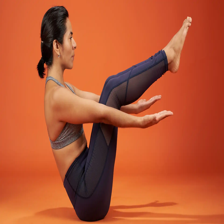

In [85]:
# Load the best model and evaluate it by an example
model = ViTForImageClassification.from_pretrained("./vit-base-yoga-demo/checkpoint-760")
model.eval()

# Process the image 
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")
    return inputs

## Preview the image, change its size to 224x224
image_path = "Test/image6.png"
image = Image.open(image_path)
image = image.resize((224, 224))
image


In [83]:

inputs = preprocess_image(image_path)

# Predict
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print(f"Predicted class index: {predicted_class_idx}")
print(f"Predicted class name: {class_label.int2str(predicted_class_idx)}")

Predicted class index: 38
Predicted class name: Adho Mukha Vrksasana
